Author: Valentin Malykh, [valentin.malykh@phystech.edu](valentin.malykh@phystech.edu)

Original Author: [Jonathan Raiman](http://github.com/JonathanRaiman)

In [2]:
%load_ext autoreload
%autoreload 2
import theano, theano.tensor as T
import numpy as np
import theano_lstm
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h1 align="center">Organization Info</h1> 


**Схема задания**:
- [Проверочные вопросы](#Check-Questions)
- [Описание задания](#The-Practical-Task)
- [Повторение семинара](#RNN-Drop-In)

**Оформление дз**: 
- Присылайте выполненное задание на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2016_fall <номер_группы> <фамилия>``, к примеру -- ``ML2016_fall 401 ivanov``
- Выполненное дз сохраните в файл ``<фамилия>_<группа>_task<номер>.ipnb``, к примеру -- ``ivanov_401_task1.ipnb``

**Вопросы**:
- Присылайте вопросы на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2016_fall Question <Содержание вопроса>``

--------
- **PS1**: Мы используем автоматические фильтры, и просто не найдем ваше дз, если вы не аккуратно его подпишите.
- **PS2**: Напоминаем, что дедлайны жесткие, письма пришедшие после автоматически удаляются =( чтобы соблазна не было 

# Check Questions

**Вопрос 1**: Что такое backpropagation?

Метод обратного распространения ошибки, используемый при обучении многослойного прецептрона с учителем. Заключается в распространении сигналов ошибки от выходов к входам и является обобщением градиентного спуска.

**Вопрос 2**: Какие активационные функции вы знаете?

1) Жесткая пороговая функция
$$
\begin{equation*}
\phi(s) = 
 \begin{cases}
   1 &\text{$s \geq a$}\\
   0 &\text{$s < a$}
 \end{cases}
\end{equation*}
$$

2) Линейный порог или гистерезис
$$
\begin{equation*}
\phi(s) = 
 \begin{cases}
   1 &\text{$s \geq a$}\\
   s &\text{$ a > s \geq a$}\\
   0 &\text{$s < -a$}
 \end{cases}
\end{equation*}
$$

3) Сигмоидальная функция

$$\phi(s) = \frac{1}{1 + exp(-as)}$$

4) Гиперболический тангенс
$$th(\frac{s}{a})$$

*а* в первых двух функциях параметр порога, в последних - параметр наклона

**Вопрос 3**: Чем они интересны, почему среди множества всех возможных функций были выбраны именно эти?

Функция активации должна быть непрерывной, диффеенцируемой, монотонно неубывающей. Также желательно, чтоб ее производная легко находилась. Обычно используется сигмоид. 

**Вопрос 4**: Чем deep learning отличается от обычных нейронных сетей?

В глубоком обучении под "глубиной" подразумевается глубина графа в модели, то есть, например, в простой нейронной сети это количество слоев между входом и выходом. То есть термин deep learning применителен к нейронным сетям, у которых не один слой нейронов, а много

**Вопрос 5**: Что такое свертка?

В свёрточной нейронной сети вместо огромного количества весов используем небольшую сверточную матрицу весов, которую двигаем по всему обрабатываемому слою, формируя после каждого сдвига сигнал активации для нейронов следующего слоя с аналогичной позицией. Матрица, или ядро свертки, графически кодирует какой-либо один признак, например, наличие какой-то линии. Тогда следующий слой, получившийся в результате операции свёртки такой матрицей весов, показывает наличие данной линии в обрабатываемом слое и её координаты. Так формируется feature map. то есть свертка - проход ядром свертки по всем нейронам нижнего слоя для активации нейронов верхнего слоя - получения карты признаков. 

**Вопрос 6**: Что такое скрытое состояние?

В LSTM выделяют состояние ячейки и скрытое состояние. Первое видоизменяется путем прохождения через гейты забывания и обновления и имеет аналогию с фичей субъекта (например, пол персонажа, если анализируем текст). Второе видоизменяется путем приенения сигмоида к прерыдущему скрытому состоянию и гип. тангенса к текущему вычисленному состоянию ячейки. Скрытое состояние несет функцию "памяти" или предыдущего опыта нейронной сети (например, помогает определить форму глагола, который получит на следующем входе). 

**Вопрос 7**: Что такое embedding?

Представление объекта, или его отображение из множетва объектов в линейное векторное пространство с сохранением информации. 

# The Practical Task
Your task today is to program Gated Recurrent Unit (GRU), basing on the code of LSTM & RNN bundled with this homework.

Below is the same seminar on RNNs, but with additional info for [GRU](#The-GRU). Have fun.

## RNN Drop In
### The inputs
<img src="img/rnn_data.png">

### The one step [at the time]
<img src="img/rnn_timestep_2.png">

### The working modes
<img src="img/rnn_masking_2.png">

### The Long Short-Term Memory
<img src="img/lstm.png">

The more comprehensive introduction (with math!) could be found [here](http://deeplearning.net/tutorial/lstm.html).

## A Nonsensical Language Model using Theano LSTM

Today we will train a **nonsensical** language model !

We will first collect some language data, convert it to numbers, and then feed it to a recurrent neural network and ask it to predict upcoming words. When we are done we will have a machine that can generate sentences from our made-up language ad infinitum!

### Collect Language Data

The first step here is to get some data. Since we are basing our language on nonsense, we need to generate good nonsense using a sampler.

Our sampler will take a probability table as input, e.g. a language where people are equally likely to say "a" or "b" would be written as follows:

    nonsense = Sampler({"a": 0.5, "b": 0.5})
    
We get samples from this language like this:

    word = nonsense()
    
We overloaded the `__call__` method and got this syntactic sugar.

In [3]:
## Fake dataset:

class Sampler:
    def __init__(self, prob_table):
        total_prob = 0.0
        if type(prob_table) is dict:
            for key, value in prob_table.items():
                total_prob += value
        elif type(prob_table) is list:
            prob_table_gen = {}
            for key in prob_table:
                prob_table_gen[key] = 1.0 / (float(len(prob_table)))
            total_prob = 1.0
            prob_table = prob_table_gen
        else:
            raise ArgumentError("__init__ takes either a dict or a list as its first argument")
        if total_prob <= 0.0:
            raise ValueError("Probability is not strictly positive.")
        self._keys = []
        self._probs = []
        for key in prob_table:
            self._keys.append(key)
            self._probs.append(prob_table[key] / total_prob)
        
    def __call__(self):
        sample = random.random()
        seen_prob = 0.0
        for key, prob in zip(self._keys, self._probs):
            if (seen_prob + prob) >= sample:
                return key
            else:
                seen_prob += prob
        return key

### Parts of Speech

Now that we have a `Sampler` we can create a couple different word groups that our language uses to distinguish between different probability distributions easily:

In [4]:
samplers = {
    "punctuation": Sampler({".": 0.49, ",": 0.5, ";": 0.03, "?": 0.05, "!": 0.05}),
    "stop": Sampler({"the": 10, "from": 5, "a": 9, "they": 3, "he": 3, "it" : 2.5, "she": 2.7, "in": 4.5}),
    "noun": Sampler(["cat", "broom", "boat", "dog", "car", "wrangler", "mexico", "lantern", 
                     "book", "paper", "joke","calendar", "ship", "event"]),
    "verb": Sampler(["ran", "stole", "carried", "could", "would", "do", "can", "carry", "catapult", "jump", "duck"]),
    "adverb": Sampler(["rapidly", "calmly", "cooly", "in jest", "fantastically", "angrily", "dazily"])
    }

### Simple Grammar

To create sentences from our language we create a simple recursion that goes as follows:

1. If the sentence we have ends with a full stop, a question mark, or an exclamation point then end at once!
2. Else our sentence should have:
    * A stop word
    * A noun
    * An adverb (with prob 0.3), or 2 adverbs (with prob 0.3*0.3=0.09)
    * A verb
    * Another noun (with prob 0.2), or 2 more nouns connected by a dash (with prob 0.2*0.1=0.02)
3. If our sentence is now over 500 characters, add a full stop and end at once!
4. Else add some punctuation and go back to (1)

In [5]:
def generate_nonsense(word = ""):
    if word.endswith("."):
        return word
    else:
        if len(word) > 0:
            word += " "
        word += samplers["stop"]()
        word += " " + samplers["noun"]()
        if random.random() > 0.7:
            word += " " + samplers["adverb"]()
            if random.random() > 0.7:
                word += " " + samplers["adverb"]()
        word += " " + samplers["verb"]()
        if random.random() > 0.8:
            word += " " + samplers["noun"]()
            if random.random() > 0.9:
                word += "-" + samplers["noun"]()
        if len(word) > 500:
            word += "."
        else:
            word += " " + samplers["punctuation"]()
        return generate_nonsense(word)

In [6]:
def generate_dataset(total_size, ):
    sentences = []
    for i in range(total_size):
        sentences.append(generate_nonsense())
    return sentences

# generate dataset                
lines = generate_dataset(100)

### Utilities

Now that we have our training corpus for our language model (optionally you could gather an actual corpus from the web :), we can now create our first utility, `Vocab`, that will hold the mapping from words to an index, and perfom the conversions from words to indices and vice-versa:

In [7]:
### Utilities:
class Vocab:
    __slots__ = ["word2index", "index2word", "unknown"]
    
    def __init__(self, index2word = None):
        self.word2index = {}
        self.index2word = []
        
        # add unknown word:
        self.add_words(["**UNKNOWN**"])
        self.unknown = 0
        
        if index2word is not None:
            self.add_words(index2word)
                
    def add_words(self, words):
        for word in words:
            if word not in self.word2index:
                self.word2index[word] = len(self.word2index)
                self.index2word.append(word)
                       
    def __call__(self, line):
        """
        Convert from numerical representation to words
        and vice-versa.
        """
        if type(line) is np.ndarray:
            return " ".join([self.index2word[word] for word in line])
        if type(line) is list:
            if len(line) > 0:
                if line[0] is int:
                    return " ".join([self.index2word[word] for word in line])
            indices = np.zeros(len(line), dtype=np.int32)
        else:
            line = line.split(" ")
            indices = np.zeros(len(line), dtype=np.int32)
        
        for i, word in enumerate(line):
            indices[i] = self.word2index.get(word, self.unknown)
            
        return indices
    
    @property
    def size(self):
        return len(self.index2word)
    
    def __len__(self):
        return len(self.index2word)

### Create a Mapping from numbers to words

Now we can use the `Vocab` class to gather all the words and store an Index:

In [8]:
vocab = Vocab()
for line in lines:
    vocab.add_words(line.split(" "))

To send our sentences in one big chunk to our neural network we transform each sentence into a row vector and place each of these rows into a bigger matrix that holds all these rows. Not all sentences have the same length, so we will pad those that are too short with 0s in `pad_into_matrix`:

In [9]:
def pad_into_matrix(rows, padding = 0):
    if len(rows) == 0:
        return np.array([0, 0], dtype=np.int32)
    lengths = map(len, rows)
    width = max(lengths)
    height = len(rows)
    mat = np.empty([height, width], dtype=rows[0].dtype)
    mat.fill(padding)
    for i, row in enumerate(rows):
        mat[i, 0:len(row)] = row
    return mat, list(lengths)

In [10]:
# transform into big numerical matrix of sentences:
numerical_lines = []
for line in lines:
    numerical_lines.append(vocab(line))
numerical_lines, numerical_lengths = pad_into_matrix(numerical_lines)

## Build a Recurrent Neural Network

Now the real work is upon us! Thank goodness we have our language data ready. We now create a recurrent neural network by connecting an Embedding $E$ for each word in our corpus, and stacking some special cells together to form a prediction function. Mathematically we want:

$$\mathrm{argmax_{E, \Phi}} {\bf P}(w_{k+1}| w_{k}, \dots, w_{0}; E, \Phi) = f(x, h)$$

with $f(\cdot, \cdot)$ the function our recurrent neural network performs at each timestep that takes as inputs:

* an observation $x$, and
* a previous state $h$,

and outputs a probability distribution $\hat{p}$ over the next word.

We have $x = E[ w_{k}]$ our observation at time $k$, and $h$ the internal state of our neural network, and $\Phi$ is the set of parameters used by our classifier, and recurrent neural network, and $E$ is the embedding for our words.

In practice we will obtain $E$ and $\Phi$ iteratively using gradient descent on the error our network is making in its prediction. To do this we define our error as the [Kullback-Leibler divergence](http://en.wikipedia.org/wiki/Kullback–Leibler_divergence) (a distance between probability distributions) between our estimate of $\hat{p} = {\bf P}(w_{k+1}| w_{k}, \dots, w_{0}; E, \Phi)$ and the actual value of ${\bf P}(w_{k+1}| w_{k}, \dots, w_{0})$ from the data (e.g. a probability distribution that is 1 for word $w_k$ and 0 elsewhere).


#### Theano LSTM StackedCells function

To build this predictive model we make use of `theano_lstm`, a Python module for building recurrent neural networks using Theano. Its code is bundled with this package. The first step we take is to declare what kind of cells we want to use by declaring a celltype. There are many different celltypes we can use, but the most common these days (and incidentally most effective) are `RNN` and `LSTM`. For a more in-depth discussion of how these work I suggest checking out [Arxiv](http://arxiv.org/find/all/1/all:+lstm/0/1/0/all/0/1), or [Alex Graves' website](http://www.cs.toronto.edu/~graves/), or [Wikipedia](http://en.wikipedia.org/wiki/Long_short_term_memory). Here we use `celltype = LSTM`.
```
    self.model = StackedCells(input_size, celltype=celltype, layers =[hidden_size] * stack_size)
```    
Once we've declared what kind of cells we want to use, we can now choose to add an Embedding to map integers (indices) to vectors (and in our case map words to their indices, then indices to word vectors we wish to train). Intuitively this lets the network separate and recognize what it is "seeing" or "receiving" at each timestep. To add an Embedding we create `Embedding(vocabulary_size, size_of_embedding_vectors)` and insert it at the begging of the `StackedCells`'s layers list (thereby telling `StackedCells` that this Embedding layer needs to be activated before the other ones):
```    
    # add an embedding
    self.model.layers.insert(0, Embedding(vocab_size, input_size))
```    
The final output of our network needs to be a probability distribution over the next words (but in different application areas this could be a sentiment classification, a decision, a topic, etc...) so we add another layer that maps the internal state of the LSTMs to a probability distribution over the all the words in our language. To ensure that our prediction is indeed a probability distribution we "activate" our layer with a Softmax, meaning that we will exponentiate every value of the output, $q_i = e^{x_i}$, so that all values are positive, and then we will divide the output by its sum so that the output sums to 1:

$$p_i = \frac{q_i}{\sum_j q_j}\text{, and }\sum_i p_i = 1.$$
```  
    # add a classifier:
    self.model.layers.append(Layer(hidden_size, vocab_size, activation = softmax))
```    
For convenience we wrap this all in one class below.

#### Prediction

We have now defined our network. At each timestep we can produce a probability distribution for each input index:
```
    def create_prediction(self, greedy=False):
        def step(idx, *states):
            # new hiddens are the states we need to pass to LSTMs
            # from past. Because the StackedCells also include
            # the embeddings, and those have no state, we pass
            # a "None" instead:
            new_hiddens = [None] + list(states)

            new_states = self.model.forward(idx, prev_hiddens = new_hiddens)
            return new_states[1:]
        ...
```          
Our inputs are an integer matrix Theano symbolic variable:
```       
        ...
        # in sequence forecasting scenario we take everything
        # up to the before last step, and predict subsequent
        # steps ergo, 0 ... n - 1, hence:
        inputs = self.input_mat[:, 0:-1]
        num_examples = inputs.shape[0]
        # pass this to Theano's recurrence relation function:
        ....
```
Scan receives our recurrence relation `step` from above, and also needs to know what will be outputted at each step in `outputs_info`. We give `outputs_info` a set of variables corresponding to the hidden states of our StackedCells. Some of the layers have no hidden state, and thus we should simply pass a `None` to Theano, while others do require some initial state. In those cases with wrap their initial state inside a dictionary:
```
    def has_hidden(layer):
        """
        Whether a layer has a trainable
        initial hidden state.
        """
        return hasattr(layer, 'initial_hidden_state')

    def matrixify(vector, n):
        return T.repeat(T.shape_padleft(vector), n, axis=0)

    def initial_state(layer, dimensions = None):
        """
        Initalizes the recurrence relation with an initial hidden state
        if needed, else replaces with a "None" to tell Theano that
        the network **will** return something, but it does not need
        to send it to the next step of the recurrence
        """
        if dimensions is None:
            return layer.initial_hidden_state if has_hidden(layer) else None
        else:
            return matrixify(layer.initial_hidden_state, dimensions) if has_hidden(layer) else None

    def initial_state_with_taps(layer, dimensions = None):
        """Optionally wrap tensor variable into a dict with taps=[-1]"""
        state = initial_state(layer, dimensions)
        if state is not None:
            return dict(initial=state, taps=[-1])
        else:
            return None
```            
Let's now create these inital states (note how we skip layer 1, the embeddings by doing `self.model.layers[1:]` in the iteration, this is because there is no point in passing these embeddings around in our recurrence because word vectors are only seen at the timestep they are received in this network):
```
        # choose what gets outputted at each timestep:
        outputs_info = [initial_state_with_taps(layer, num_examples) for layer in self.model.layers[1:]]
        result, _ = theano.scan(fn=step,
                                sequences=[inputs.T],
                                outputs_info=outputs_info)

        if greedy:
            return result[0]
        # softmaxes are the last layer of our network,
        # and are at the end of our results list:
        return result[-1].transpose((2,0,1))
        # we reorder the predictions to be:
        # 1. what row / example
        # 2. what timestep
        # 3. softmax dimension
```
#### Error Function:

Our error function uses `theano_lstm`'s `masked_loss` method. This method allows us to define ranges over which a probability distribution should obey a particular target distribution. We control this method by setting start and end points for these ranges. In doing so we mask the areas where we do not care what the network predicted.

In our case our network predicts words we care about during the sentence, but when we pad our short sentences with 0s to fill our matrix, we do not care what the network does there, because this is happening outside the sentence we collected:
```
    def create_cost_fun (self):
        # create a cost function that
        # takes each prediction at every timestep
        # and guesses next timestep's value:
        what_to_predict = self.input_mat[:, 1:]
        # because some sentences are shorter, we
        # place masks where the sentences end:
        # (for how long is zero indexed, e.g. an example going from `[2,3)`)
        # has this value set 0 (here we substract by 1):
        for_how_long = self.for_how_long - 1
        # all sentences start at T=0:
        starting_when = T.zeros_like(self.for_how_long)
                                 
        self.cost = masked_loss(self.predictions,
                                what_to_predict,
                                for_how_long,
                                starting_when).sum()
```                                
#### Training Function

We now have a cost function. To perform gradient descent we now need to tell Theano how each parameter must be updated at every training epoch. We `theano_lstm`'s `create_optimization_udpates` method to generate a dictionary of updates and to apply special gradient descent rules that accelerate and facilitate training (for instance scaling the gradients when they are too large or too little, and preventing gradients from becoming too big and making our model numerically unstable -- in this example we use [Adadelta](http://arxiv.org/abs/1212.5701):
```
    def create_training_function(self):
        updates, _, _, _, _ = create_optimization_updates(self.cost, self.params, method="adadelta")
        self.update_fun = theano.function(
            inputs=[self.input_mat, self.for_how_long],
            outputs=self.cost,
            updates=updates,
            allow_input_downcast=True)
```
PS: our parameters are obtained by calling `self.model.params`:
```
    @property
    def params(self):
        return self.model.params
```  

# The GRU

The idea behind a GRU layer is quite similar to that of a LSTM layer, as are the equations. 

\begin{aligned}  z &=\sigma(x_tU^z + s_{t-1} W^z) \\  r &=\sigma(x_t U^r +s_{t-1} W^r) \\  h &= tanh(x_t U^h + (s_{t-1} \circ r) W^h) \\  s_t &= (1 - z) \circ h + z \circ s_{t-1}  \end{aligned}  

A GRU has two gates, a reset gate $r$, and an update gate $z$.  Intuitively, the reset gate determines how to combine the new input with the previous memory, and the update gate defines how much of the previous memory to keep around. If we set the reset to all 1’s and  update gate to all 0’s we again arrive at our plain RNN model. The basic idea of using a gating mechanism to learn long-term dependencies is the same as in a LSTM, but there are a few key differences:

* A GRU has two gates, an LSTM has three gates.
* GRUs don’t possess and internal memory $c_t$ that is different from the exposed hidden state. They don’t have the output gate that is present in LSTMs.
* The input and forget gates are coupled by an update gate $z$ and the reset gate $r$ is applied directly to the previous hidden state. Thus, the responsibility of the reset gate in a LSTM is really split up into both $r$ and $z$.
* We don’t apply a second nonlinearity when computing the output.

### The way to work through this home work
... is to read carefully the bundled code of LSTM class, read theory (may be using some additional sources) and implement the GRU building on LSTM class implementation. Or write it totally by yourselves, which is also acceptable, but could be more time consuming.

### The template code to work with:

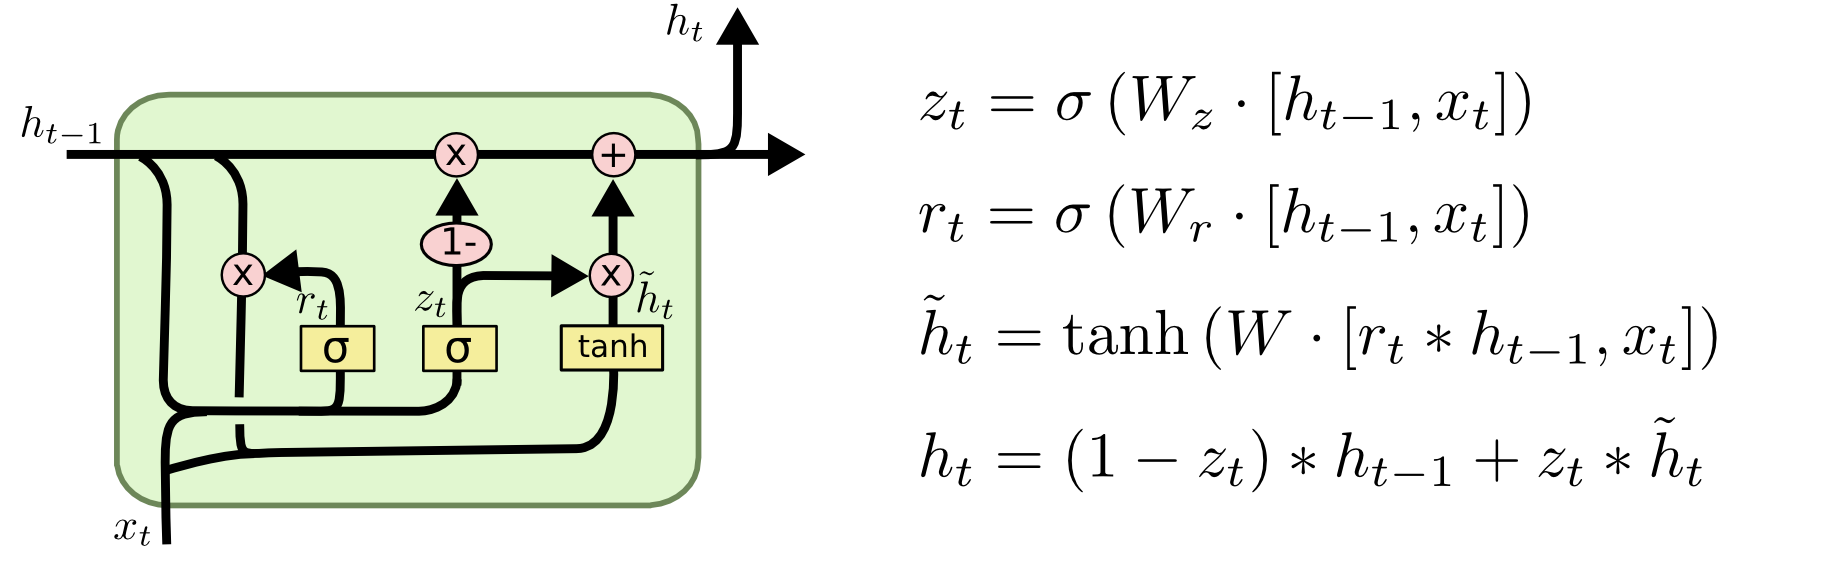

In [28]:
from IPython.display import Image
Image('http://datareview.info/wp-content/uploads/2015/09/16.png')

In [30]:
class GRU(RNN):
    def create_variables(self):
        self.reset_layer = RNN(self.input_size, self.hidden_size, activation = T.nnet.sigmoid)
        self.update_layer = RNN(self.input_size, self.hidden_size, activation = T.nnet.sigmoid)
        self.candidate_layer = theano_lstm.RNN(self.input_size, self.hidden_size, activation = T.tanh)
        self.internal_layers = [
            self.reset_layer,
            self.update_layer,
            self.candidate_layer
        ]
        self.initial_hidden_state = create_shared(self.hidden_size, name="GRU.initial_hidden_state")

    @property
    def params(self):
        return [param for layer in self.internal_layers for param in layer.params]

    @params.setter
    def params(self, param_list):
        assert(len(param_list) == 6)
        self.reset_layer.params = param_list[0:2]
        self.update_layer.params = param_list[2:4]
        self.candidate_layer.params = param_list[4:6]
    
    def activate(self, x, h):
        r_gate = self.reset_layer.activate(x, h)
        h_gate = self.candidate_layer.activate(x, r_gate * h)
        z_gate = self.update_layer.activate(x, h)
        new_h = (1.0 - z_gate) * h + z_gate * h_gate
        return new_h

### Final Code

In [12]:
from theano_lstm import *

In [14]:
def softmax(x):
    """
    Wrapper for softmax, helps with
    pickling, and removing one extra
    dimension that Theano adds during
    its exponential normalization.
    """
    return T.nnet.softmax(x.T)

In [15]:
def has_hidden(layer):
    """
    Whether a layer has a trainable
    initial hidden state.
    """
    return hasattr(layer, 'initial_hidden_state')

In [16]:
def matrixify(vector, n):
    return T.repeat(T.shape_padleft(vector), n, axis=0)

In [17]:
def initial_state(layer, dimensions = None):
    """
    Initalizes the recurrence relation with an initial hidden state
    if needed, else replaces with a "None" to tell Theano that
    the network **will** return something, but it does not need
    to send it to the next step of the recurrence
    """
    if dimensions is None:
        return layer.initial_hidden_state if has_hidden(layer) else None
    else:
        return matrixify(layer.initial_hidden_state, dimensions) if has_hidden(layer) else None
    

In [18]:
def initial_state_with_taps(layer, dimensions = None):
    """Optionally wrap tensor variable into a dict with taps=[-1]"""
    state = initial_state(layer, dimensions)
    if state is not None:
        return dict(initial=state, taps=[-1])
    else:
        return None

In [19]:
class Model:
    """
    Simple predictive model for forecasting words from
    sequence using LSTMs. Choose how many LSTMs to stack
    what size their memory should be, and how many
    words can be predicted.
    """
    def __init__(self, hidden_size, input_size, vocab_size, stack_size=1, celltype=LSTM):
        # declare model
        self.model = StackedCells(input_size, celltype=celltype, layers =[hidden_size] * stack_size)
        # add an embedding
        self.model.layers.insert(0, Embedding(vocab_size, input_size))
        # add a classifier:
        self.model.layers.append(Layer(hidden_size, vocab_size, activation = softmax))
        # inputs are matrices of indices,
        # each row is a sentence, each column a timestep
        self._stop_word   = theano.shared(np.int32(999999999), name="stop word")
        self.for_how_long = T.ivector()
        self.input_mat = T.imatrix()
        self.priming_word = T.iscalar()
        self.srng = T.shared_randomstreams.RandomStreams(np.random.randint(0, 1024))
        # create symbolic variables for prediction:
        self.predictions = self.create_prediction()
        # create symbolic variable for greedy search:
        self.greedy_predictions = self.create_prediction(greedy=True)
        # create gradient training functions:
        self.create_cost_fun()
        self.create_training_function()
        self.create_predict_function()
        
    def stop_on(self, idx):
        self._stop_word.set_value(idx)
        
    @property
    def params(self):
        return self.model.params
                                 
    def create_prediction(self, greedy=False):
        def step(idx, *states):
            # new hiddens are the states we need to pass to LSTMs
            # from past. Because the StackedCells also include
            # the embeddings, and those have no state, we pass
            # a "None" instead:
            new_hiddens = [None] + list(states)
            
            new_states = self.model.forward(idx, prev_hiddens = new_hiddens)
            if greedy:
                new_idxes = new_states[-1]
                new_idx   = new_idxes.argmax()
                # provide a stopping condition for greedy search:
                return ([new_idx.astype(self.priming_word.dtype)] + new_states[1:-1]), theano.scan_module.until(T.eq(new_idx,self._stop_word))
            else:
                return new_states[1:]
        # in sequence forecasting scenario we take everything
        # up to the before last step, and predict subsequent
        # steps ergo, 0 ... n - 1, hence:
        inputs = self.input_mat[:, 0:-1]
        num_examples = inputs.shape[0]
        # pass this to Theano's recurrence relation function:
        
        # choose what gets outputted at each timestep:
        if greedy:
            outputs_info = [dict(initial=self.priming_word, taps=[-1])] + [initial_state_with_taps(layer) for layer in self.model.layers[1:-1]]
            result, _ = theano.scan(fn=step,
                                n_steps=200,
                                outputs_info=outputs_info)
        else:
            outputs_info = [initial_state_with_taps(layer, num_examples) for layer in self.model.layers[1:]]
            result, _ = theano.scan(fn=step,
                                sequences=[inputs.T],
                                outputs_info=outputs_info)
                                 
        if greedy:
            return result[0]
        # softmaxes are the last layer of our network,
        # and are at the end of our results list:
        return result[-1].transpose((2,0,1))
        # we reorder the predictions to be:
        # 1. what row / example
        # 2. what timestep
        # 3. softmax dimension
                                 
    def create_cost_fun (self):
        # create a cost function that
        # takes each prediction at every timestep
        # and guesses next timestep's value:
        what_to_predict = self.input_mat[:, 1:]
        # because some sentences are shorter, we
        # place masks where the sentences end:
        # (for how long is zero indexed, e.g. an example going from `[2,3)`)
        # has this value set 0 (here we substract by 1):
        for_how_long = self.for_how_long - 1
        # all sentences start at T=0:
        starting_when = T.zeros_like(self.for_how_long)
                                 
        self.cost = masked_loss(self.predictions,
                                what_to_predict,
                                for_how_long,
                                starting_when).sum()
        
    def create_predict_function(self):
        self.pred_fun = theano.function(
            inputs=[self.input_mat],
            outputs =self.predictions,
            allow_input_downcast=True
        )
        
        self.greedy_fun = theano.function(
            inputs=[self.priming_word],
            outputs=T.concatenate([T.shape_padleft(self.priming_word), self.greedy_predictions]),
            allow_input_downcast=True
        )
                                 
    def create_training_function(self):
        updates, _, _, _, _ = create_optimization_updates(self.cost, self.params, method="adadelta")
        self.update_fun = theano.function(
            inputs=[self.input_mat, self.for_how_long],
            outputs=self.cost,
            updates=updates,
            allow_input_downcast=True)
        
    def __call__(self, x):
        return self.pred_fun(x)

### Construct model

We now declare the model and parametrize it to use an RNN (GRU), and make predictions in the range provided by our vocabulary. We also tell the greedy reconstruction search that it can consider a sentence as being over when the symbol corresponding to a period appears:


In [31]:
%%time
# construct model & theano functions:
model = Model(
    input_size=10,
    hidden_size=10,
    vocab_size=len(vocab),
    stack_size=3, # make this bigger, but makes compilation slow
    celltype=GRU  # here you should use your freshly written GRU
)
model.stop_on(vocab.word2index["."])

CPU times: user 1min 3s, sys: 844 ms, total: 1min 4s
Wall time: 1min 29s


### Train Model

We run 10,000 times through our data and every 500 epochs of training we output what the model considers to be a natural continuation to the sentence "the":


In [191]:
# train:
for i in range(10000):
    error = model.update_fun(numerical_lines, numerical_lengths)
    if i % 100 == 0:
        print("epoch %(epoch)d, error=%(error).2f" % ({"epoch": i, "error": error}))
    if i % 500 == 0:
        print(vocab(model.greedy_fun(vocab.word2index["the"])))

epoch 0, error=3877.55
the .
epoch 100, error=3873.32
epoch 200, error=3868.80
epoch 300, error=3863.65
epoch 400, error=3857.58
epoch 500, error=3850.15
the .
epoch 600, error=3840.67
epoch 700, error=3828.21
epoch 800, error=3811.36
epoch 900, error=3787.88
epoch 1000, error=3754.51
the .
epoch 1100, error=3707.27
epoch 1200, error=3652.82
epoch 1300, error=3794.47
epoch 1400, error=3633.05
epoch 1500, error=3749.59
the .
epoch 1600, error=3622.81
epoch 1700, error=3728.75
epoch 1800, error=3615.40
epoch 1900, error=3711.92
epoch 2000, error=3608.67
the .
epoch 2100, error=3697.46
epoch 2200, error=3602.14
epoch 2300, error=3684.72
epoch 2400, error=3595.66
epoch 2500, error=3673.21
the .
epoch 2600, error=3589.14
epoch 2700, error=3662.57
epoch 2800, error=3582.49
epoch 2900, error=3652.51
epoch 3000, error=3575.61
the .
epoch 3100, error=3642.76
epoch 3200, error=3568.39
epoch 3300, error=3633.05
epoch 3400, error=3560.71
epoch 3500, error=3623.09
the event .
epoch 3600, error=3552

In [26]:
# train:
for i in range(10000):
    error = model.update_fun(numerical_lines, numerical_lengths)
    if i % 100 == 0:
        print("epoch %(epoch)d, error=%(error).2f" % ({"epoch": i, "error": error}))
    if i % 500 == 0:
        print(vocab(model.greedy_fun(vocab.word2index["the"])))

epoch 0, error=3970.47
the dazily the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
epoch 100, error=3383.96
epoch 200, error=2827.25
epoch 300, error=2513.62
epoch 400, error=2371.97
epoch 500, error=2293.98
the event ran , a event ran , a event ran , a